## Introduction


### The dataset
The Breast Cancer (Wisconsin) Diagnosis dataset contains the diagnosis and a set of 30 features describing the characteristics of the cell nuclei present in the digitized image of a of a fine needle aspirate (FNA) of a breast mass.

### Ten real-valued features are computed for each cell nucleus:

* radius (mean of distances from center to points on the perimeter);
* texture (standard deviation of gray-scale values);
* perimeter;
* area;
* smoothness (local variation in radius lengths);
* compactness (perimeter^2 / area - 1.0);
* concavity (severity of concave portions of the contour);
* concave points (number of concave portions of the contour);
* symmetry;
* fractal dimension (“coastline approximation” - 1).
* The mean, standard error (SE) and “worst” or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. We will analyze the features to understand the predictive value for diagnosis. We will then create models using two different algorithms and use the models to predict the diagnosis.

### Fine needle aspiration

Fine-needle aspiration (FNA) is a diagnostic procedure used to investigate lumps or masses. In this technique, a thin (23–25 gauge), hollow needle is inserted into the mass for sampling of cells that, after being stained, will be examined under a microscope (biopsy). Fine-needle aspiration biopsies are very safe minor surgical procedures.

### Prerequisites
We will include in this Kernel two functions from packages not present on Kaggle, as follows:

* ggbiplot for representation of data grouped on category in the PCA transform components plane;
* ggplot2g for representation of data grouped on category in the plane defined by pairs of features;

The category used in both cases will be the diagnosis.

### 1. Data Importing & Cleaning & Inspecting

#### 1.1 Import dataset

**wbcd means ‘wisconsin breast cancer data’**

### Data Loading and Cleaning

In [1]:
library(needs)
needs(readr,
      dplyr,
      ggplot2,
      corrplot,
      gridExtra,
      pROC,
      MASS,
      caTools,
      caret,
      caretEnsemble,
      doMC)
#registerDoMC(cores = 3)


Load `package:needs` in an interactive session to set auto-load flag




In [2]:
data <- read.csv("../input/breast-cancer-wisconsin-data/data.csv")

In [3]:
str(data)

'data.frame':	569 obs. of  33 variables:
 $ id                     : int  842302 842517 84300903 84348301 84358402 843786 844359 84458202 844981 84501001 ...
 $ diagnosis              : Factor w/ 2 levels "B","M": 2 2 2 2 2 2 2 2 2 2 ...
 $ radius_mean            : num  18 20.6 19.7 11.4 20.3 ...
 $ texture_mean           : num  10.4 17.8 21.2 20.4 14.3 ...
 $ perimeter_mean         : num  122.8 132.9 130 77.6 135.1 ...
 $ area_mean              : num  1001 1326 1203 386 1297 ...
 $ smoothness_mean        : num  0.1184 0.0847 0.1096 0.1425 0.1003 ...
 $ compactness_mean       : num  0.2776 0.0786 0.1599 0.2839 0.1328 ...
 $ concavity_mean         : num  0.3001 0.0869 0.1974 0.2414 0.198 ...
 $ concave.points_mean    : num  0.1471 0.0702 0.1279 0.1052 0.1043 ...
 $ symmetry_mean          : num  0.242 0.181 0.207 0.26 0.181 ...
 $ fractal_dimension_mean : num  0.0787 0.0567 0.06 0.0974 0.0588 ...
 $ radius_se              : num  1.095 0.543 0.746 0.496 0.757 ...
 $ texture_se            

In [4]:
data$diagnosis <- as.factor(data$diagnosis)
# the 33 column is not right
data[,33] <- NULL

In [5]:
summary(data)

       id            diagnosis  radius_mean      texture_mean  
 Min.   :     8670   B:357     Min.   : 6.981   Min.   : 9.71  
 1st Qu.:   869218   M:212     1st Qu.:11.700   1st Qu.:16.17  
 Median :   906024             Median :13.370   Median :18.84  
 Mean   : 30371831             Mean   :14.127   Mean   :19.29  
 3rd Qu.:  8813129             3rd Qu.:15.780   3rd Qu.:21.80  
 Max.   :911320502             Max.   :28.110   Max.   :39.28  
 perimeter_mean     area_mean      smoothness_mean   compactness_mean 
 Min.   : 43.79   Min.   : 143.5   Min.   :0.05263   Min.   :0.01938  
 1st Qu.: 75.17   1st Qu.: 420.3   1st Qu.:0.08637   1st Qu.:0.06492  
 Median : 86.24   Median : 551.1   Median :0.09587   Median :0.09263  
 Mean   : 91.97   Mean   : 654.9   Mean   :0.09636   Mean   :0.10434  
 3rd Qu.:104.10   3rd Qu.: 782.7   3rd Qu.:0.10530   3rd Qu.:0.13040  
 Max.   :188.50   Max.   :2501.0   Max.   :0.16340   Max.   :0.34540  
 concavity_mean    concave.points_mean symmetry_mean   

**There aren’t NA values.**

**The dataset is a bit unbalanced:**

In [6]:
prop.table(table(data$diagnosis))


        B         M 
0.6274165 0.3725835 

**There is a great correlation between some variables:**

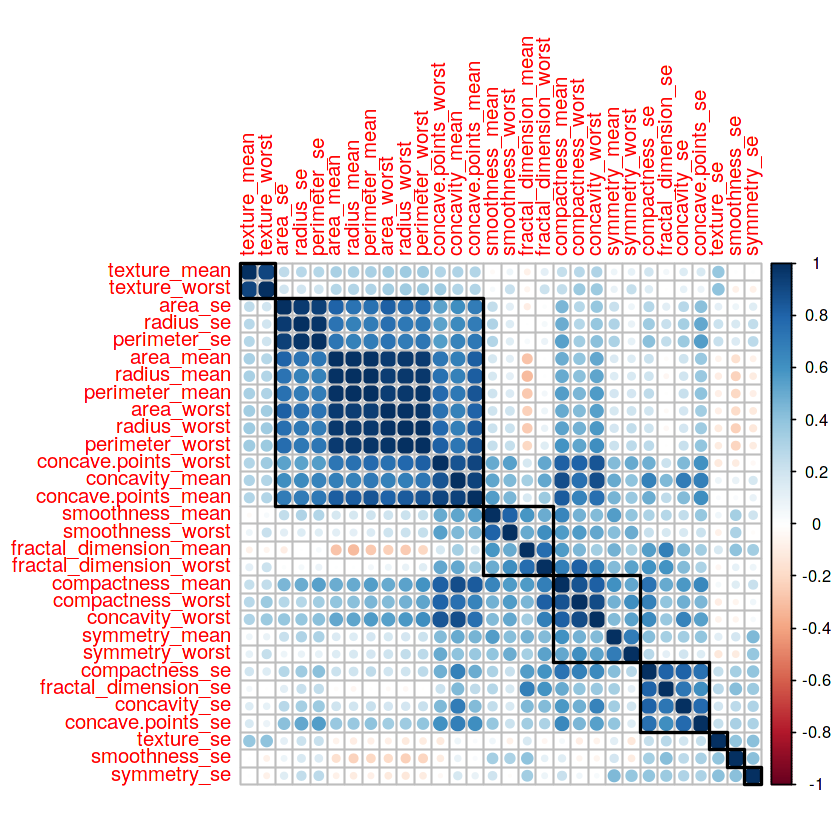

In [7]:
corr_mat <- cor(data[,3:ncol(data)])
corrplot(corr_mat, order = "hclust", tl.cex = 1, addrect = 8)

## Modeling

**We are going to get a training and a testing set to use when building some models:**

In [8]:
set.seed(1234)
data_index <- createDataPartition(data$diagnosis, p=0.7, list = FALSE)
train_data <- data[data_index, -1]
test_data <- data[-data_index, -1]

**We will try some data transformations too in some models:**

### Data preprocessing {.tabset}

Because there are so much correlation some machine learning models can fail. We are going to create
1. a PCA and LDA version of the data

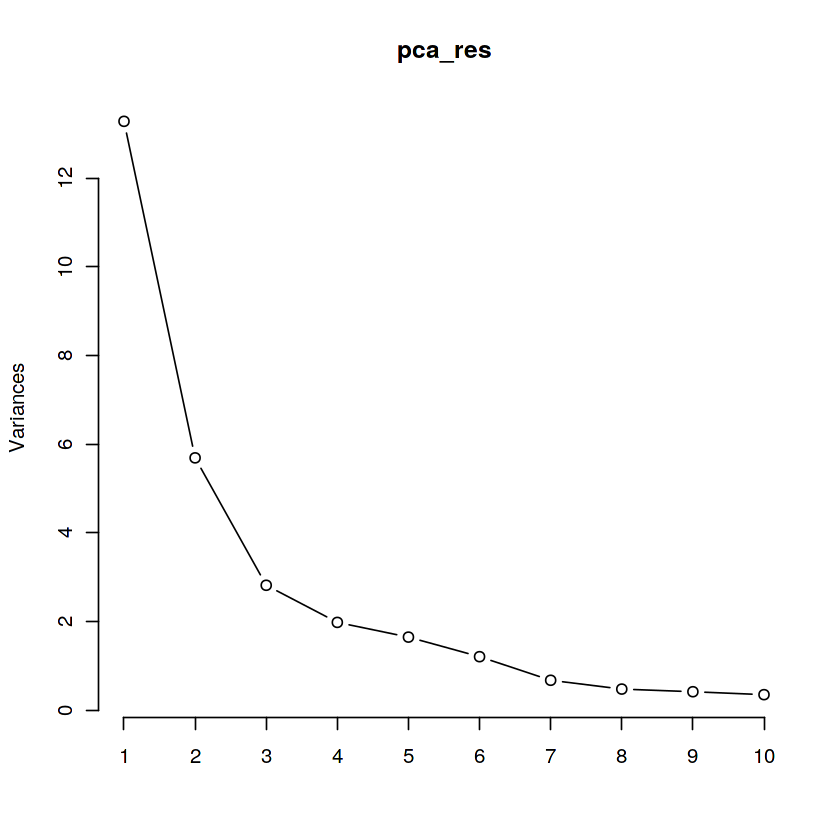

In [9]:
pca_res <- prcomp(data[,3:ncol(data)], center = TRUE, scale = TRUE)
plot(pca_res, type="l")

**Let’s try LDA instead of PCA. LDA take in consideration the different classes and could get better results**

In [10]:
lda_res <- lda(diagnosis~., data, center = TRUE, scale = TRUE) 
lda_df <- predict(lda_res, data)$x %>% as.data.frame() %>% cbind(diagnosis=data$diagnosis)
lda_res

Call:
lda(diagnosis ~ ., data = data, center = TRUE, scale = TRUE)

Prior probabilities of groups:
        B         M 
0.6274165 0.3725835 

Group means:
        id radius_mean texture_mean perimeter_mean area_mean smoothness_mean
B 26543825    12.14652     17.91476       78.07541  462.7902      0.09247765
M 36818050    17.46283     21.60491      115.36538  978.3764      0.10289849
  compactness_mean concavity_mean concave.points_mean symmetry_mean
B       0.08008462     0.04605762          0.02571741      0.174186
M       0.14518778     0.16077472          0.08799000      0.192909
  fractal_dimension_mean radius_se texture_se perimeter_se  area_se
B             0.06286739 0.2840824   1.220380     2.000321 21.13515
M             0.06268009 0.6090825   1.210915     4.323929 72.67241
  smoothness_se compactness_se concavity_se concave.points_se symmetry_se
B   0.007195902     0.02143825   0.02599674       0.009857653  0.02058381
M   0.006780094     0.03228117   0.04182401       0.015060

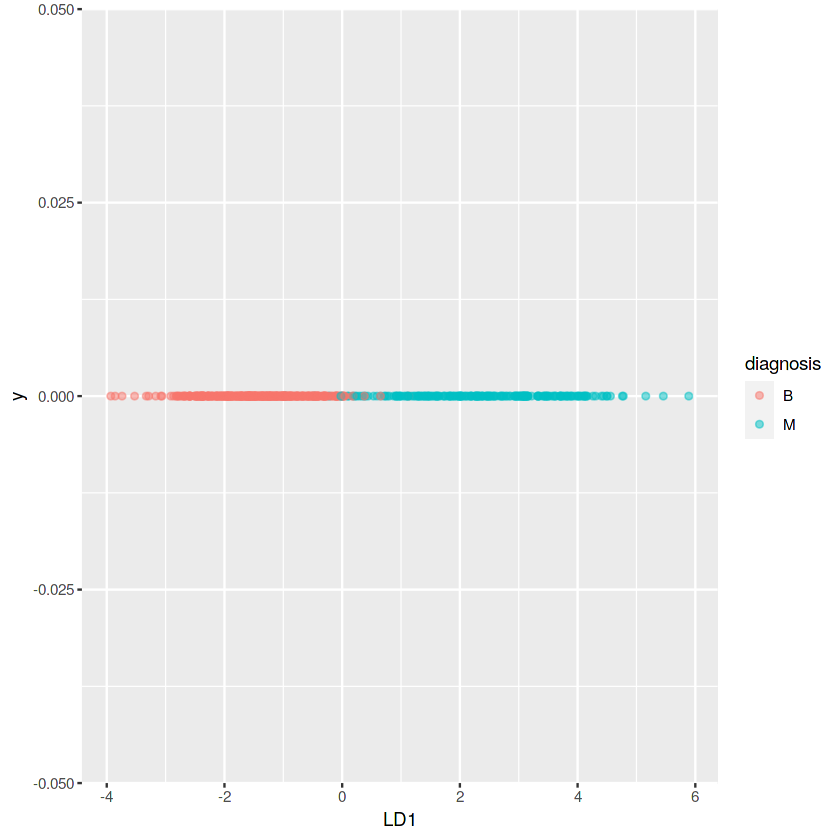

In [11]:
ggplot(lda_df, aes(x=LD1, y=0, col=diagnosis)) + geom_point(alpha=0.5)

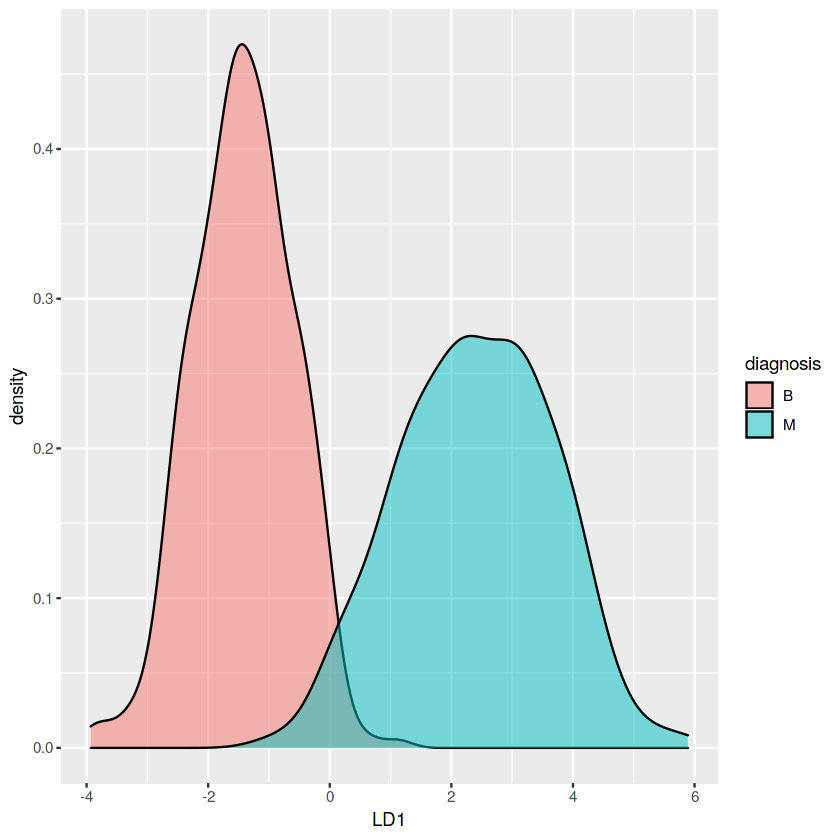

In [12]:
ggplot(lda_df, aes(x=LD1, fill=diagnosis)) + geom_density(alpha=0.5)

**We are going to create a training and test set of these data:**

In [13]:
train_data_lda <- lda_df[data_index,]
test_data_lda <- lda_df[-data_index,]

### Applying machine learning models

In [14]:
fitControl <- trainControl(method="cv",
                            number = 5,
                            preProcOptions = list(thresh = 0.99), # threshold for pca preprocess
                            classProbs = TRUE,
                            summaryFunction = twoClassSummary)

In [15]:
model_lda <- train(diagnosis~.,
                       train_data_lda,
                       method="lda2",
                       #tuneLength = 10,
                       metric="ROC",
                       preProc = c("center", "scale"),
                       trControl=fitControl)

In [16]:
pred_lda <- predict(model_lda, test_data_lda)
cm_lda <- confusionMatrix(pred_lda, test_data_lda$diagnosis, positive = "M")
cm_lda

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 107   6
         M   0  57
                                          
               Accuracy : 0.9647          
                 95% CI : (0.9248, 0.9869)
    No Information Rate : 0.6294          
    P-Value [Acc > NIR] : < 2e-16         
                                          
                  Kappa : 0.9228          
                                          
 Mcnemar's Test P-Value : 0.04123         
                                          
            Sensitivity : 0.9048          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9469          
             Prevalence : 0.3706          
         Detection Rate : 0.3353          
   Detection Prevalence : 0.3353          
      Balanced Accuracy : 0.9524          
                                          
       'Positive' Class : M               
                              

,B,M
B vs. M,0.9980715,0.9980715


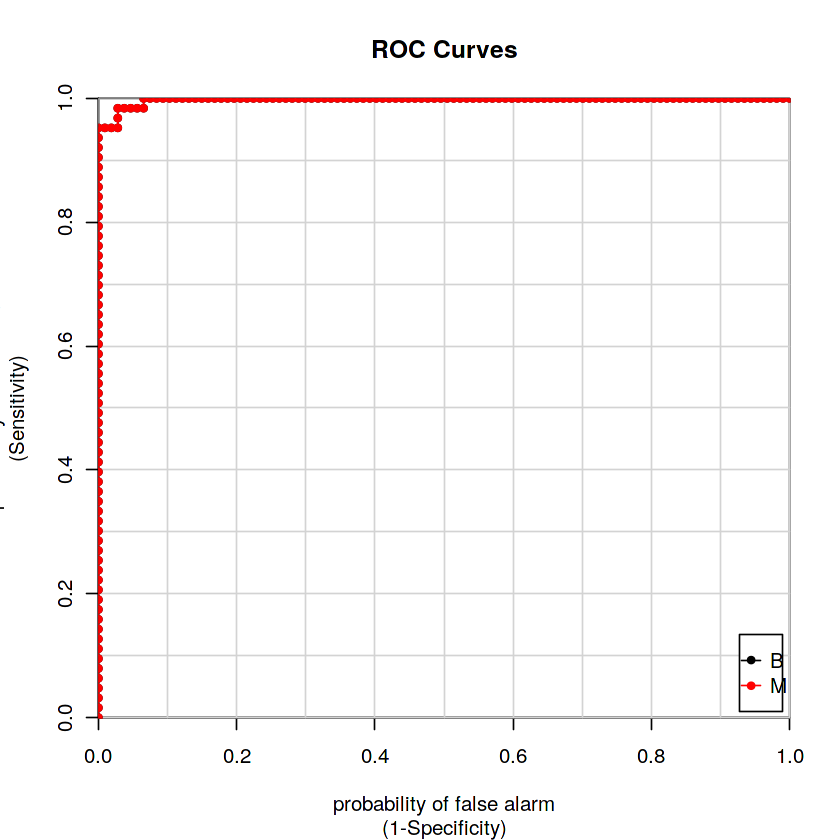

In [17]:
pred_prob_lda <- predict(model_lda, test_data_lda, type="prob")
#roc_lda <- roc(test_data_lda$diagnosis, pred_prob_lda$M)
#plot(roc_lda)
colAUC(pred_prob_lda, test_data_lda$diagnosis, plotROC=TRUE)

Let’s try random forest:

In [18]:
model_rf <- train(diagnosis~.,
                  train_data,
                  method="ranger",
                  metric="ROC",
                  #tuneLength=10,
                  #tuneGrid = expand.grid(mtry = c(2, 3, 6)),
                  preProcess = c('center', 'scale'),
                  trControl=fitControl)

In [19]:
pred_rf <- predict(model_rf, test_data)
cm_rf <- confusionMatrix(pred_rf, test_data$diagnosis, positive = "M")
cm_rf

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 105   5
         M   2  58
                                         
               Accuracy : 0.9588         
                 95% CI : (0.917, 0.9833)
    No Information Rate : 0.6294         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.9109         
                                         
 Mcnemar's Test P-Value : 0.4497         
                                         
            Sensitivity : 0.9206         
            Specificity : 0.9813         
         Pos Pred Value : 0.9667         
         Neg Pred Value : 0.9545         
             Prevalence : 0.3706         
         Detection Rate : 0.3412         
   Detection Prevalence : 0.3529         
      Balanced Accuracy : 0.9510         
                                         
       'Positive' Class : M              
                                         

### Random forest with PCA

In [20]:
model_pca_rf <- train(diagnosis~.,
                  train_data,
                  method="ranger",
                  metric="ROC",
                  #tuneLength=10,
                  #tuneGrid = expand.grid(mtry = c(2, 3, 6)),
                  preProcess = c('center', 'scale', 'pca'),
                  trControl=fitControl)

Warning message:
“model fit failed for Fold2: mtry=17, min.node.size=1, splitrule=gini Error in ranger::ranger(dependent.variable.name = ".outcome", data = x,  : 
  User interrupt or internal error.
”
Warning message:
“model fit failed for Fold2: mtry=17, min.node.size=1, splitrule=extratrees Error in ranger::ranger(dependent.variable.name = ".outcome", data = x,  : 
  User interrupt or internal error.
”
Warning message:
“model fit failed for Fold3: mtry=17, min.node.size=1, splitrule=gini Error in ranger::ranger(dependent.variable.name = ".outcome", data = x,  : 
  User interrupt or internal error.
”
Warning message:
“model fit failed for Fold3: mtry=17, min.node.size=1, splitrule=extratrees Error in ranger::ranger(dependent.variable.name = ".outcome", data = x,  : 
  User interrupt or internal error.
”
Warning message:
“model fit failed for Fold5: mtry=17, min.node.size=1, splitrule=gini Error in ranger::ranger(dependent.variable.name = ".outcome", data = x,  : 
  User interrupt or i

In [21]:
pred_pca_rf <- predict(model_pca_rf, test_data)
cm_pca_rf <- confusionMatrix(pred_pca_rf, test_data$diagnosis, positive = "M")
cm_pca_rf

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 106   6
         M   1  57
                                         
               Accuracy : 0.9588         
                 95% CI : (0.917, 0.9833)
    No Information Rate : 0.6294         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.9103         
                                         
 Mcnemar's Test P-Value : 0.1306         
                                         
            Sensitivity : 0.9048         
            Specificity : 0.9907         
         Pos Pred Value : 0.9828         
         Neg Pred Value : 0.9464         
             Prevalence : 0.3706         
         Detection Rate : 0.3353         
   Detection Prevalence : 0.3412         
      Balanced Accuracy : 0.9477         
                                         
       'Positive' Class : M              
                                         

In [22]:
model_knn <- train(diagnosis~.,
                   train_data,
                   method="knn",
                   metric="ROC",
                   preProcess = c('center', 'scale'),
                   tuneLength=10,
                   trControl=fitControl)

In [23]:
pred_knn <- predict(model_knn, test_data)
cm_knn <- confusionMatrix(pred_knn, test_data$diagnosis, positive = "M")
cm_knn

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 106   8
         M   1  55
                                          
               Accuracy : 0.9471          
                 95% CI : (0.9019, 0.9755)
    No Information Rate : 0.6294          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8839          
                                          
 Mcnemar's Test P-Value : 0.0455          
                                          
            Sensitivity : 0.8730          
            Specificity : 0.9907          
         Pos Pred Value : 0.9821          
         Neg Pred Value : 0.9298          
             Prevalence : 0.3706          
         Detection Rate : 0.3235          
   Detection Prevalence : 0.3294          
      Balanced Accuracy : 0.9318          
                                          
       'Positive' Class : M               
                              

Setting levels: control = B, case = M

Setting direction: controls < cases



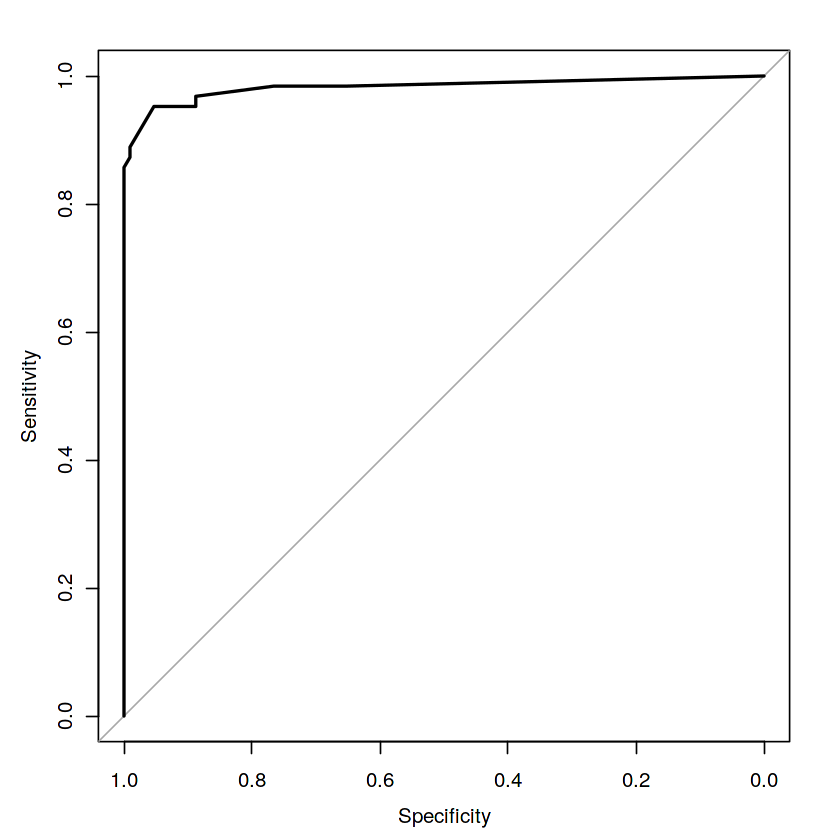

In [24]:
pred_prob_knn <- predict(model_knn, test_data, type="prob")
roc_knn <- roc(test_data$diagnosis, pred_prob_knn$M)
plot(roc_knn)

In [25]:
model_nnet <- train(diagnosis~.,
                    train_data,
                    method="nnet",
                    metric="ROC",
                    preProcess=c('center', 'scale'),
                    trace=FALSE,
                    tuneLength=10,
                    trControl=fitControl)

In [26]:
pred_nnet <- predict(model_nnet, test_data)
cm_nnet <- confusionMatrix(pred_nnet, test_data$diagnosis, positive = "M")
cm_nnet

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 106   4
         M   1  59
                                          
               Accuracy : 0.9706          
                 95% CI : (0.9327, 0.9904)
    No Information Rate : 0.6294          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9363          
                                          
 Mcnemar's Test P-Value : 0.3711          
                                          
            Sensitivity : 0.9365          
            Specificity : 0.9907          
         Pos Pred Value : 0.9833          
         Neg Pred Value : 0.9636          
             Prevalence : 0.3706          
         Detection Rate : 0.3471          
   Detection Prevalence : 0.3529          
      Balanced Accuracy : 0.9636          
                                          
       'Positive' Class : M               
                              

In [27]:
model_pca_nnet <- train(diagnosis~.,
                    train_data,
                    method="nnet",
                    metric="ROC",
                    preProcess=c('center', 'scale', 'pca'),
                    tuneLength=10,
                    trace=FALSE,
                    trControl=fitControl)

In [28]:
pred_pca_nnet <- predict(model_pca_nnet, test_data)
cm_pca_nnet <- confusionMatrix(pred_pca_nnet, test_data$diagnosis, positive = "M")
cm_pca_nnet

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 105   5
         M   2  58
                                         
               Accuracy : 0.9588         
                 95% CI : (0.917, 0.9833)
    No Information Rate : 0.6294         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.9109         
                                         
 Mcnemar's Test P-Value : 0.4497         
                                         
            Sensitivity : 0.9206         
            Specificity : 0.9813         
         Pos Pred Value : 0.9667         
         Neg Pred Value : 0.9545         
             Prevalence : 0.3706         
         Detection Rate : 0.3412         
   Detection Prevalence : 0.3529         
      Balanced Accuracy : 0.9510         
                                         
       'Positive' Class : M              
                                         

In [29]:
model_lda_nnet <- train(diagnosis~.,
                    train_data_lda,
                    method="nnet",
                    metric="ROC",
                    preProcess=c('center', 'scale'),
                    tuneLength=10,
                    trace=FALSE,
                    trControl=fitControl)

In [30]:
pred_lda_nnet <- predict(model_lda_nnet, test_data_lda)
cm_lda_nnet <- confusionMatrix(pred_lda_nnet, test_data_lda$diagnosis, positive = "M")
cm_lda_nnet

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 107   4
         M   0  59
                                          
               Accuracy : 0.9765          
                 95% CI : (0.9409, 0.9936)
    No Information Rate : 0.6294          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9489          
                                          
 Mcnemar's Test P-Value : 0.1336          
                                          
            Sensitivity : 0.9365          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9640          
             Prevalence : 0.3706          
         Detection Rate : 0.3471          
   Detection Prevalence : 0.3471          
      Balanced Accuracy : 0.9683          
                                          
       'Positive' Class : M               
                              

In [31]:
model_svm <- train(diagnosis~.,
                    train_data,
                    method="svmRadial",
                    metric="ROC",
                    preProcess=c('center', 'scale'),
                    trace=FALSE,
                    trControl=fitControl)

In [32]:
pred_svm <- predict(model_svm, test_data)
cm_svm <- confusionMatrix(pred_svm, test_data$diagnosis, positive = "M")
cm_svm

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 105   4
         M   2  59
                                          
               Accuracy : 0.9647          
                 95% CI : (0.9248, 0.9869)
    No Information Rate : 0.6294          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9238          
                                          
 Mcnemar's Test P-Value : 0.6831          
                                          
            Sensitivity : 0.9365          
            Specificity : 0.9813          
         Pos Pred Value : 0.9672          
         Neg Pred Value : 0.9633          
             Prevalence : 0.3706          
         Detection Rate : 0.3471          
   Detection Prevalence : 0.3588          
      Balanced Accuracy : 0.9589          
                                          
       'Positive' Class : M               
                              

In [33]:
model_nb <- train(diagnosis~.,
                    train_data,
                    method="nb",
                    metric="ROC",
                    preProcess=c('center', 'scale'),
                    trace=FALSE,
                    trControl=fitControl)

Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace

In [34]:
pred_nb <- predict(model_nb, test_data)
cm_nb <- confusionMatrix(pred_nb, test_data$diagnosis, positive = "M")
cm_nb

Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 1”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 2”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 3”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 4”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 5”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 6”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 7”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 8”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 9”
Warning message in FUN(X[[i]], ...):
“Numerical 0 probability for all classes with observation 10”
Warning message in 

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 102  10
         M   5  53
                                          
               Accuracy : 0.9118          
                 95% CI : (0.8586, 0.9498)
    No Information Rate : 0.6294          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.8077          
                                          
 Mcnemar's Test P-Value : 0.3017          
                                          
            Sensitivity : 0.8413          
            Specificity : 0.9533          
         Pos Pred Value : 0.9138          
         Neg Pred Value : 0.9107          
             Prevalence : 0.3706          
         Detection Rate : 0.3118          
   Detection Prevalence : 0.3412          
      Balanced Accuracy : 0.8973          
                                          
       'Positive' Class : M               
                              

In [35]:
model_lda_nb <- train(diagnosis~.,
                    train_data_lda,
                    method="nb",
                    metric="ROC",
                    preProcess=c('center', 'scale'),
                    trace=FALSE,
                    trControl=fitControl)

Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”
Warning message:
“In density.default(xx, ...) :
 extra argument ‘trace’ will be disregarded”


In [36]:
pred_lda_nb <- predict(model_lda_nb, test_data_lda)
cm_lda_nb <- confusionMatrix(pred_lda_nb, test_data$diagnosis, positive = "M")
cm_lda_nb

Confusion Matrix and Statistics

          Reference
Prediction   B   M
         B 107   4
         M   0  59
                                          
               Accuracy : 0.9765          
                 95% CI : (0.9409, 0.9936)
    No Information Rate : 0.6294          
    P-Value [Acc > NIR] : <2e-16          
                                          
                  Kappa : 0.9489          
                                          
 Mcnemar's Test P-Value : 0.1336          
                                          
            Sensitivity : 0.9365          
            Specificity : 1.0000          
         Pos Pred Value : 1.0000          
         Neg Pred Value : 0.9640          
             Prevalence : 0.3706          
         Detection Rate : 0.3471          
   Detection Prevalence : 0.3471          
      Balanced Accuracy : 0.9683          
                                          
       'Positive' Class : M               
                              

### Model result comparison

**Let’s compare the models and check their correlation:**

In [37]:
model_list <- list(RF=model_rf, PCA_RF=model_pca_rf, 
                   NNET=model_nnet, PCA_NNET=model_pca_nnet, LDA_NNET=model_lda_nnet, 
                   KNN = model_knn, SVM=model_svm, NB=model_nb, LDA_NB=model_lda_nb)
resamples <- resamples(model_list)

#### Correlation between models {.tabset .tabset-fade}

In [38]:
model_cor <- modelCor(resamples)

##### Plot

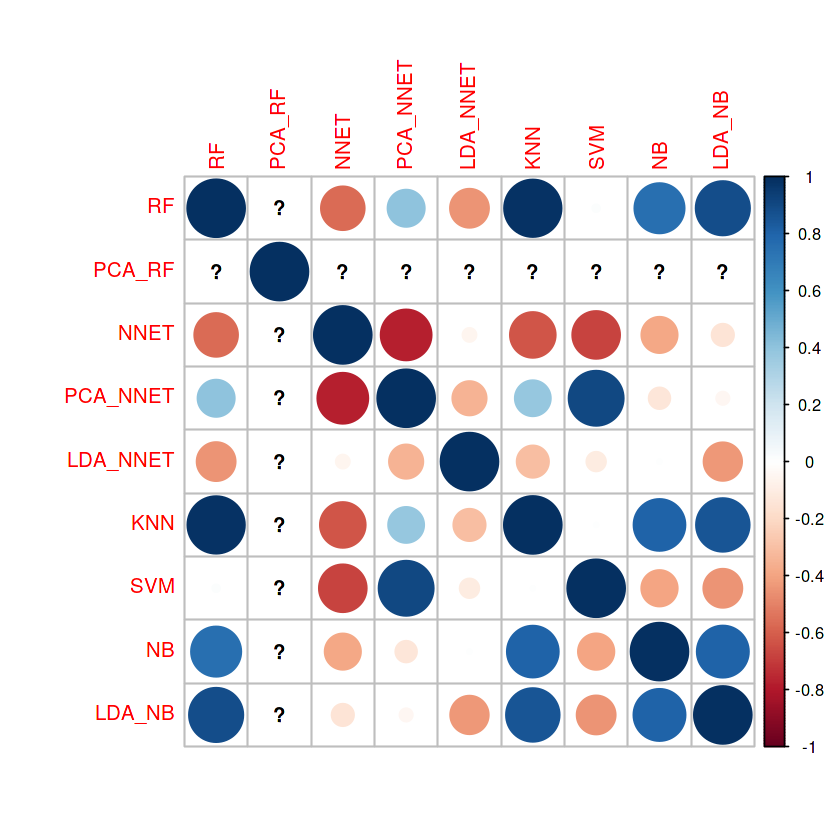

In [39]:
corrplot(model_cor)

##### Data

In [40]:
model_cor

,RF,PCA_RF,NNET,PCA_NNET,LDA_NNET,KNN,SVM,NB,LDA_NB
RF,1.00000000,NA,-0.56729085,0.40789040,-0.448889446,0.987905175,0.015383661,0.751347946,0.88051579
PCA_RF,NA,1,NA,NA,NA,NA,NA,NA,NA
NNET,-0.56729085,NA,1.00000000,-0.77363792,-0.054362049,-0.622190981,-0.679534088,-0.387138525,-0.14389074
PCA_NNET,0.40789040,NA,-0.77363792,1.00000000,-0.345490439,0.381209822,0.906458180,-0.134324021,-0.04852002
LDA_NNET,-0.44888945,NA,-0.05436205,-0.34549044,1.000000000,-0.305405213,-0.109426144,0.006270379,-0.43784836
KNN,0.98790518,NA,-0.62219098,0.38120982,-0.305405213,1.000000000,0.006033444,0.802522231,0.85835230
SVM,0.01538366,NA,-0.67953409,0.90645818,-0.109426144,0.006033444,1.000000000,-0.390882324,-0.44935284
NB,0.75134795,NA,-0.38713853,-0.13432402,0.006270379,0.802522231,-0.390882324,1.000000000,0.80997327
LDA_NB,0.88051579,NA,-0.14389074,-0.04852002,-0.437848355,0.858352305,-0.449352839,0.809973274,1.00000000


#### Comparison

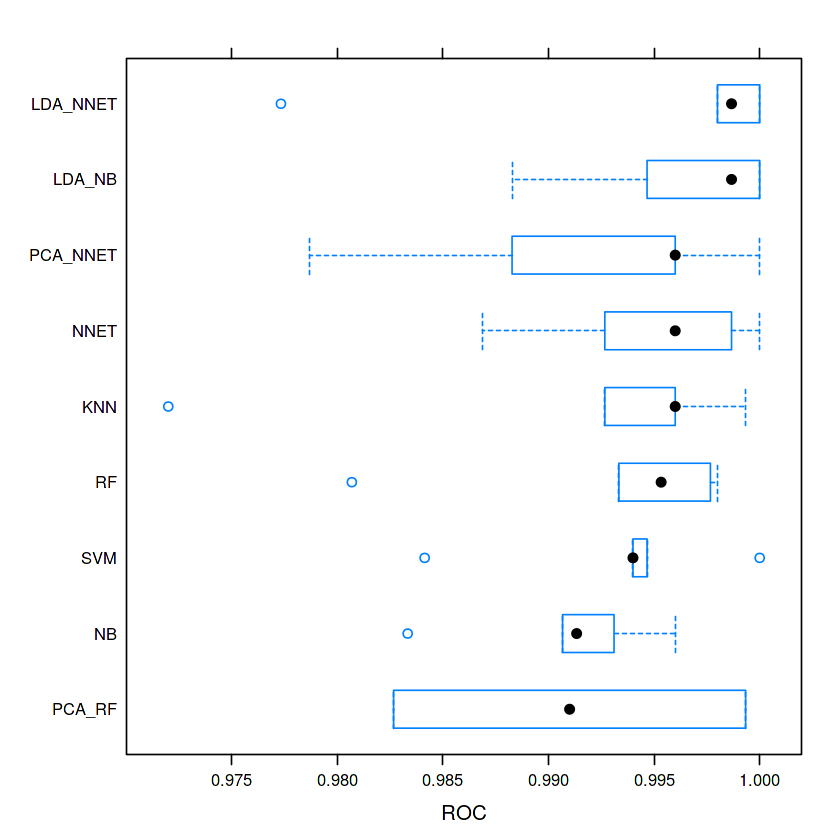

In [41]:
bwplot(resamples, metric="ROC")

We see here that some models have a great variability depending of the processed sample (NB). The models LDA_NNET, and LDA_NB achieve a great auc with some variability.

The ROC metric measure the auc of the roc curve of each model. This metric is independent of any threshold. Let’s remember how these models result with the testing dataset. Prediction classes are obtained by default with a threshold of 0.5 which could not be the best with an unbalanced dataset like this.

In [42]:
cm_list <- list(RF=cm_rf, PCA_RF=cm_pca_rf, 
                   NNET=cm_nnet, PCA_NNET=cm_pca_nnet, LDA_NNET=cm_lda_nnet, 
                   KNN = cm_knn, SVM=cm_svm, NB=cm_nb, LDA_NB=cm_lda_nb)

In [43]:
cm_list_results <- sapply(cm_list, function(x) x$byClass)
cm_list_results

,RF,PCA_RF,NNET,PCA_NNET,LDA_NNET,KNN,SVM,NB,LDA_NB
Sensitivity,0.9206349,0.9047619,0.9365079,0.9206349,0.9365079,0.8730159,0.9365079,0.8412698,0.9365079
Specificity,0.9813084,0.9906542,0.9906542,0.9813084,1.0000000,0.9906542,0.9813084,0.9532710,1.0000000
Pos Pred Value,0.9666667,0.9827586,0.9833333,0.9666667,1.0000000,0.9821429,0.9672131,0.9137931,1.0000000
Neg Pred Value,0.9545455,0.9464286,0.9636364,0.9545455,0.9639640,0.9298246,0.9633028,0.9107143,0.9639640
Precision,0.9666667,0.9827586,0.9833333,0.9666667,1.0000000,0.9821429,0.9672131,0.9137931,1.0000000
Recall,0.9206349,0.9047619,0.9365079,0.9206349,0.9365079,0.8730159,0.9365079,0.8412698,0.9365079
F1,0.9430894,0.9421488,0.9593496,0.9430894,0.9672131,0.9243697,0.9516129,0.8760331,0.9672131
Prevalence,0.3705882,0.3705882,0.3705882,0.3705882,0.3705882,0.3705882,0.3705882,0.3705882,0.3705882
Detection Rate,0.3411765,0.3352941,0.3470588,0.3411765,0.3470588,0.3235294,0.3470588,0.3117647,0.3470588
Detection Prevalence,0.3529412,0.3411765,0.3529412,0.3529412,0.3470588,0.3294118,0.3588235,0.3411765,0.3470588


In [44]:
cm_results_max <- apply(cm_list_results, 1, which.max)

In [45]:
output_report <- data.frame(metric=names(cm_results_max), 
                            best_model=colnames(cm_list_results)[cm_results_max],
                            value=mapply(function(x,y) {cm_list_results[x,y]}, 
                            names(cm_results_max), 
                            cm_results_max))
rownames(output_report) <- NULL
output_report

metric,best_model,value
<fct>,<fct>,<dbl>
Sensitivity,NNET,0.9365079
Specificity,LDA_NNET,1.0000000
Pos Pred Value,LDA_NNET,1.0000000
Neg Pred Value,LDA_NNET,0.9639640
Precision,LDA_NNET,1.0000000
Recall,NNET,0.9365079
F1,LDA_NNET,0.9672131
Prevalence,RF,0.3705882
Detection Rate,NNET,0.3470588


**The best results for sensitivity (detection of breast cases) is LDA_NNET which also has a great F1 score.**

#### Conclusions

* We have found a model based on neural network and LDA preprocessed data with good results over the test set. This model has a sensitivity of 0.984 with a F1 score of 0.984

* We have tried an stacked model with a little improvement.

#### Next things to try:

**Use unbalanced techinques (oversampling, SMOTE…) previously to apply the models**

**Modify models to use a different metric rather than ROC (auc) which takes in consideration the best threshold**

**Try different stacking models**